# Task 5: Movie Recommendation System

## Objective
Build a system that recommends movies based on user similarity

## Dataset
MovieLens 100K Dataset (Simulated for demonstration)

## Tasks:
1. Use a user-item matrix to compute similarity scores
2. Recommend top-rated unseen movies for a given user
3. Evaluate performance using precision at K
4. Bonus: Implement item-based collaborative filtering
5. Bonus: Try matrix factorization (SVD)

In [1]:
!unzip -q "/content/archive.zip" -d "/content/archive"


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Create synthetic MovieLens dataset
np.random.seed(42)
n_users = 100
n_movies = 50
n_ratings = 2000

# Generate user-movie ratings
user_ids = np.random.randint(1, n_users + 1, n_ratings)
movie_ids = np.random.randint(1, n_movies + 1, n_ratings)
ratings = np.random.randint(1, 6, n_ratings)

# Create some patterns in ratings
for i in range(n_ratings):
    # Users tend to rate movies in certain genres higher
    if movie_ids[i] <= 10:  # Action movies
        if user_ids[i] % 3 == 0:  # Action lovers
            ratings[i] = np.random.choice([4, 5], p=[0.3, 0.7])
    elif movie_ids[i] <= 20:  # Comedy movies
        if user_ids[i] % 4 == 0:  # Comedy lovers
            ratings[i] = np.random.choice([4, 5], p=[0.2, 0.8])
    elif movie_ids[i] <= 30:  # Drama movies
        if user_ids[i] % 5 == 0:  # Drama lovers
            ratings[i] = np.random.choice([4, 5], p=[0.4, 0.6])

# Create ratings DataFrame
ratings_df = pd.DataFrame({
    'user_id': user_ids,
    'movie_id': movie_ids,
    'rating': ratings
})

# Remove duplicate ratings
ratings_df = ratings_df.drop_duplicates(subset=['user_id', 'movie_id'])

# Create movies DataFrame
movie_genres = ['Action'] * 10 + ['Comedy'] * 10 + ['Drama'] * 10 + ['Sci-Fi'] * 10 + ['Romance'] * 10
movies_df = pd.DataFrame({
    'movie_id': range(1, n_movies + 1),
    'title': [f'Movie {i}' for i in range(1, n_movies + 1)],
    'genre': movie_genres
})

print("Ratings Dataset Shape:", ratings_df.shape)
print("Movies Dataset Shape:", movies_df.shape)
print("\nFirst 10 ratings:")
print(ratings_df.head(10))
print("\nFirst 10 movies:")
print(movies_df.head(10))
print("\nRating Distribution:")
print(ratings_df['rating'].value_counts().sort_index())
print("\nGenre Distribution:")
print(movies_df['genre'].value_counts())

Ratings Dataset Shape: (1637, 3)
Movies Dataset Shape: (50, 3)

First 10 ratings:
   user_id  movie_id  rating
0       52        12       5
1       93        46       5
2       15        32       5
3       72        15       5
4       61        16       5
5       21        22       5
6       83        28       3
7       87        20       3
8       75        33       2
9       75        10       5

First 10 movies:
   movie_id     title   genre
0         1   Movie 1  Action
1         2   Movie 2  Action
2         3   Movie 3  Action
3         4   Movie 4  Action
4         5   Movie 5  Action
5         6   Movie 6  Action
6         7   Movie 7  Action
7         8   Movie 8  Action
8         9   Movie 9  Action
9        10  Movie 10  Action

Rating Distribution:
rating
1    268
2    280
3    266
4    362
5    461
Name: count, dtype: int64

Genre Distribution:
genre
Action     10
Comedy     10
Drama      10
Sci-Fi     10
Romance    10
Name: count, dtype: int64


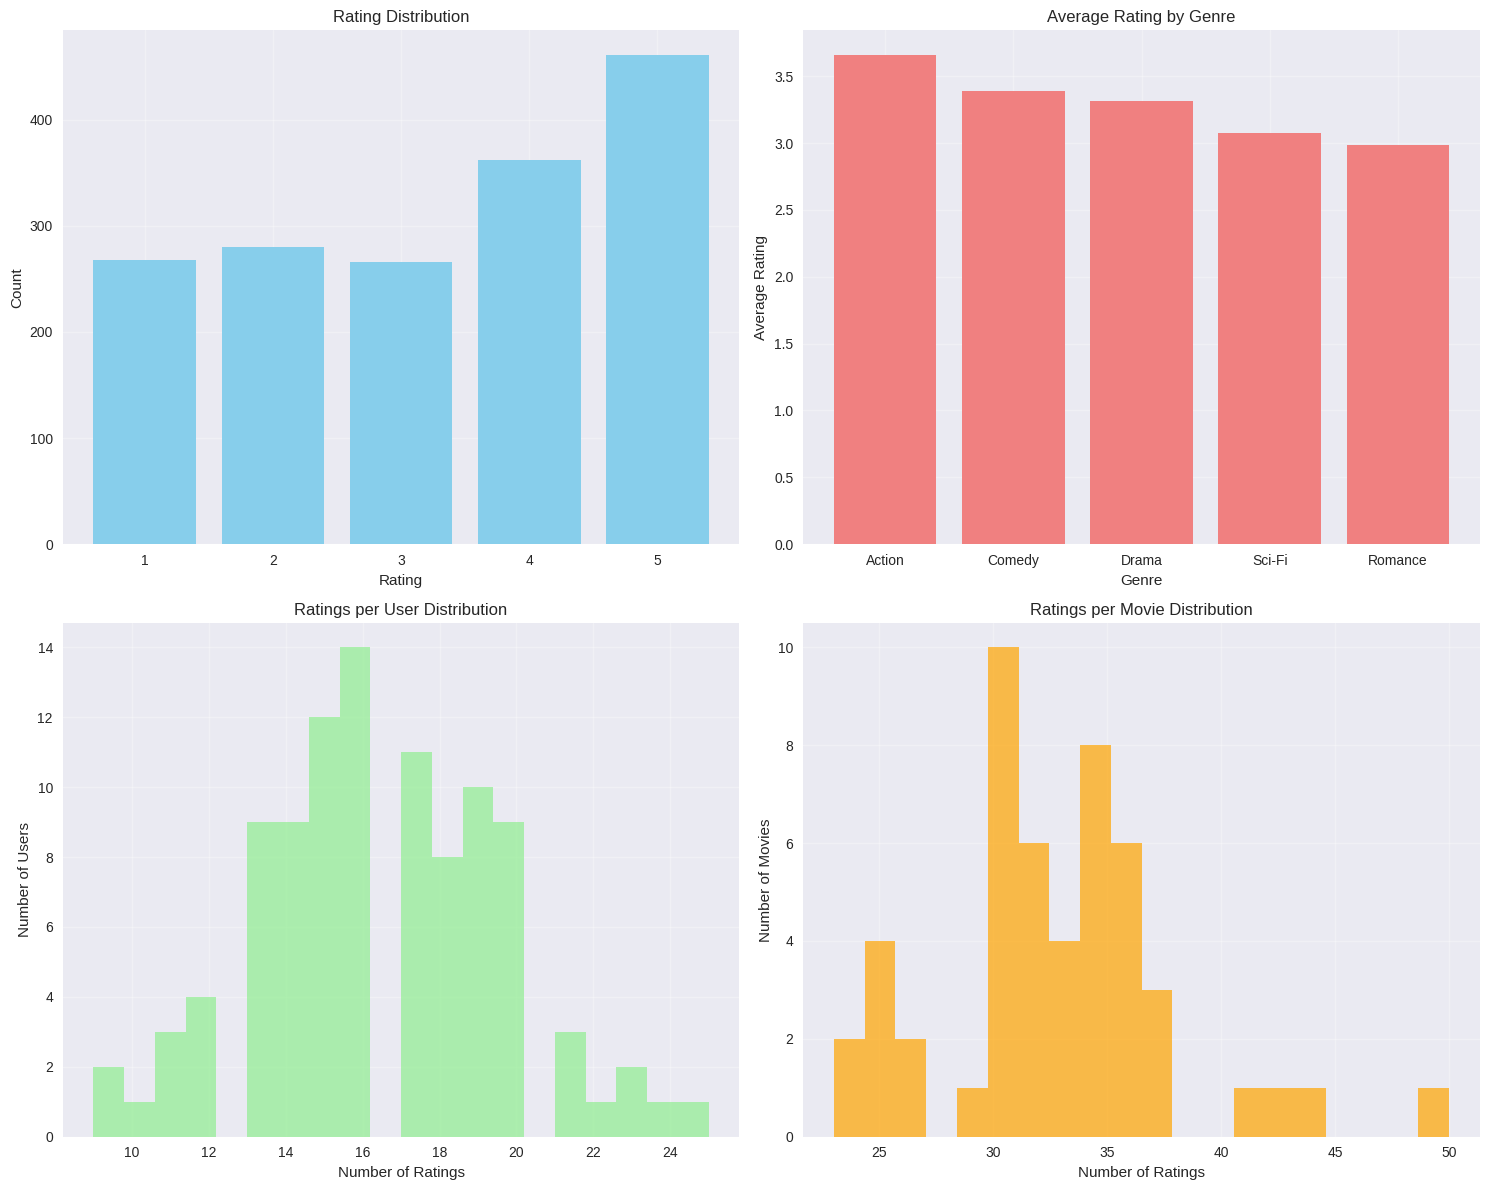


Dataset Sparsity Analysis:
Total possible ratings: 5000
Actual ratings: 1637
Sparsity: 0.6726 (67.26%)
Average ratings per user: 16.37
Average ratings per movie: 32.74


In [4]:
# Data Exploration and Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Rating distribution
rating_counts = ratings_df['rating'].value_counts().sort_index()
axes[0, 0].bar(rating_counts.index, rating_counts.values, color='skyblue')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].grid(True, alpha=0.3)

# 2. Average rating by genre
merged_df = ratings_df.merge(movies_df, on='movie_id')
genre_avg = merged_df.groupby('genre')['rating'].mean().sort_values(ascending=False)
axes[0, 1].bar(genre_avg.index, genre_avg.values, color='lightcoral')
axes[0, 1].set_xlabel('Genre')
axes[0, 1].set_ylabel('Average Rating')
axes[0, 1].set_title('Average Rating by Genre')
axes[0, 1].grid(True, alpha=0.3)

# 3. Number of ratings per user
user_rating_counts = ratings_df['user_id'].value_counts()
axes[1, 0].hist(user_rating_counts.values, bins=20, color='lightgreen', alpha=0.7)
axes[1, 0].set_xlabel('Number of Ratings')
axes[1, 0].set_ylabel('Number of Users')
axes[1, 0].set_title('Ratings per User Distribution')
axes[1, 0].grid(True, alpha=0.3)

# 4. Number of ratings per movie
movie_rating_counts = ratings_df['movie_id'].value_counts()
axes[1, 1].hist(movie_rating_counts.values, bins=20, color='orange', alpha=0.7)
axes[1, 1].set_xlabel('Number of Ratings')
axes[1, 1].set_ylabel('Number of Movies')
axes[1, 1].set_title('Ratings per Movie Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sparsity analysis
total_possible_ratings = n_users * n_movies
actual_ratings = len(ratings_df)
sparsity = (total_possible_ratings - actual_ratings) / total_possible_ratings

print(f"\nDataset Sparsity Analysis:")
print(f"Total possible ratings: {total_possible_ratings}")
print(f"Actual ratings: {actual_ratings}")
print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
print(f"Average ratings per user: {actual_ratings/n_users:.2f}")
print(f"Average ratings per movie: {actual_ratings/n_movies:.2f}")

=== Creating User-Item Matrix ===
User-Item Matrix Shape: (100, 50)
Matrix Sparsity: 0.6726

User-Item Matrix (first 10x10):
movie_id   1    2    3    4    5    6    7    8    9    10
user_id                                                   
1         0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0
2         0.0  0.0  0.0  0.0  0.0  5.0  0.0  2.0  2.0  0.0
3         5.0  4.0  5.0  0.0  0.0  5.0  0.0  5.0  5.0  5.0
4         0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  3.0  5.0
5         3.0  0.0  0.0  3.0  2.0  0.0  0.0  4.0  3.0  0.0
6         0.0  0.0  5.0  5.0  0.0  0.0  0.0  0.0  5.0  0.0
7         0.0  0.0  1.0  0.0  0.0  1.0  0.0  5.0  0.0  0.0
8         0.0  3.0  4.0  5.0  0.0  2.0  0.0  0.0  0.0  0.0
9         0.0  0.0  0.0  5.0  0.0  5.0  5.0  0.0  0.0  0.0
10        0.0  0.0  3.0  2.0  0.0  5.0  0.0  0.0  3.0  0.0


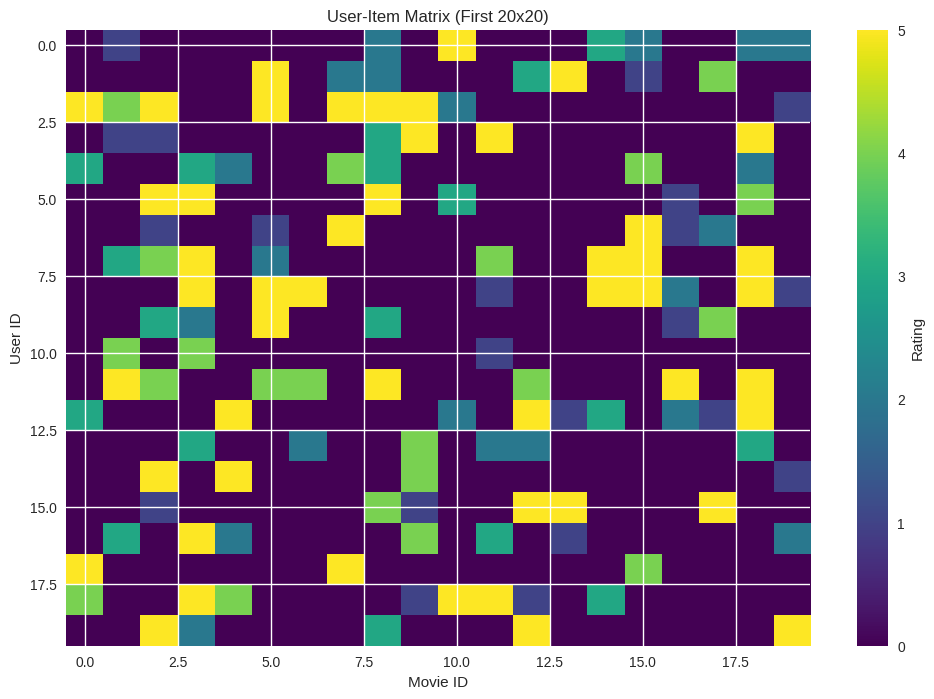


Matrix Statistics:
Number of users: 100
Number of movies: 50
Number of ratings: 1637
Average rating: 3.29
Rating standard deviation: 1.45


In [5]:
# Create User-Item Matrix
print("=== Creating User-Item Matrix ===")

# Create pivot table
user_item_matrix = ratings_df.pivot(index='user_id', columns='movie_id', values='rating')

print(f"User-Item Matrix Shape: {user_item_matrix.shape}")
print(f"Matrix Sparsity: {user_item_matrix.isnull().sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]):.4f}")

# Fill missing values with 0 for similarity calculations
user_item_matrix_filled = user_item_matrix.fillna(0)

print("\nUser-Item Matrix (first 10x10):")
print(user_item_matrix_filled.iloc[:10, :10])

# Visualize the matrix
plt.figure(figsize=(12, 8))
plt.imshow(user_item_matrix_filled.iloc[:20, :20], cmap='viridis', aspect='auto')
plt.colorbar(label='Rating')
plt.title('User-Item Matrix (First 20x20)')
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.show()

# Calculate basic statistics
print(f"\nMatrix Statistics:")
print(f"Number of users: {user_item_matrix.shape[0]}")
print(f"Number of movies: {user_item_matrix.shape[1]}")
print(f"Number of ratings: {user_item_matrix.notna().sum().sum()}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")
print(f"Rating standard deviation: {ratings_df['rating'].std():.2f}")

=== User-Based Collaborative Filtering ===
User Similarity Matrix Shape: (100, 100)

User Similarity Matrix (first 5x5):
user_id      1      2      3      4      5
user_id                                   
1        1.000  0.220  0.218  0.180  0.151
2        0.220  1.000  0.326  0.079  0.243
3        0.218  0.326  1.000  0.399  0.398
4        0.180  0.079  0.399  1.000  0.517
5        0.151  0.243  0.398  0.517  1.000


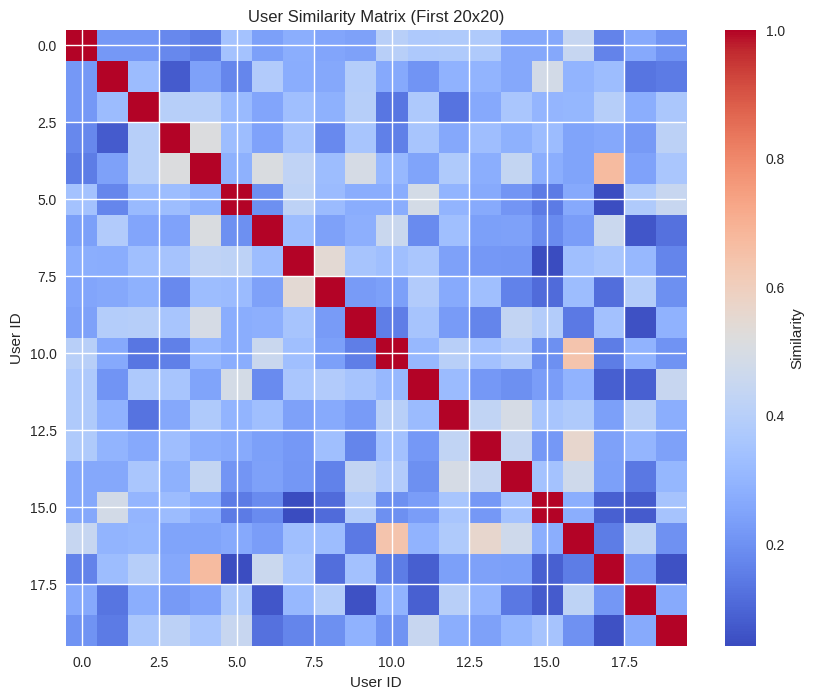


Testing recommendations for User 1:
User's rated movies: [2, 9, 11, 15, 16, 19, 20, 21, 26, 31, 34, 36, 37, 38, 40, 43, 45, 48, 49, 50]
User's ratings: [np.float64(1.0), np.float64(2.0), np.float64(5.0), np.float64(3.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(3.0), np.float64(1.0), np.float64(5.0), np.float64(5.0), np.float64(4.0), np.float64(1.0), np.float64(1.0), np.float64(4.0), np.float64(5.0), np.float64(1.0), np.float64(3.0), np.float64(5.0)]

Top 5 recommendations for User 1:
Movie 1 (Movie 1 - Action): 5.00
Movie 18 (Movie 18 - Comedy): 5.00
Movie 24 (Movie 24 - Drama): 5.00
Movie 3 (Movie 3 - Action): 4.07
Movie 23 (Movie 23 - Drama): 3.77


In [6]:
# User-Based Collaborative Filtering
print("=== User-Based Collaborative Filtering ===")

# Calculate user similarity matrix
user_similarity = cosine_similarity(user_item_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity,
                                 index=user_item_matrix_filled.index,
                                 columns=user_item_matrix_filled.index)

print(f"User Similarity Matrix Shape: {user_similarity_df.shape}")
print(f"\nUser Similarity Matrix (first 5x5):")
print(user_similarity_df.iloc[:5, :5].round(3))

# Visualize user similarity
plt.figure(figsize=(10, 8))
plt.imshow(user_similarity_df.iloc[:20, :20], cmap='coolwarm', aspect='auto')
plt.colorbar(label='Similarity')
plt.title('User Similarity Matrix (First 20x20)')
plt.xlabel('User ID')
plt.ylabel('User ID')
plt.show()

# Function to get top similar users
def get_top_similar_users(user_id, n=5):
    if user_id not in user_similarity_df.index:
        return pd.Series()

    user_similarities = user_similarity_df.loc[user_id].sort_values(ascending=False)
    # Remove self-similarity
    user_similarities = user_similarities[user_similarities.index != user_id]
    return user_similarities.head(n)

# Function to recommend movies for a user
def recommend_movies_user_based(user_id, n_recommendations=5):
    if user_id not in user_item_matrix.index:
        return pd.Series()

    # Get user's rated movies
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings.notna()].index

    # Get similar users
    similar_users = get_top_similar_users(user_id, n=10)

    if len(similar_users) == 0:
        return pd.Series()

    # Calculate weighted average ratings
    recommendations = {}

    for movie_id in user_item_matrix.columns:
        if movie_id not in rated_movies:  # Only recommend unrated movies
            weighted_sum = 0
            similarity_sum = 0

            for similar_user_id, similarity in similar_users.items():
                if similar_user_id in user_item_matrix.index:
                    rating = user_item_matrix.loc[similar_user_id, movie_id]
                    if pd.notna(rating):
                        weighted_sum += similarity * rating
                        similarity_sum += similarity

            if similarity_sum > 0:
                predicted_rating = weighted_sum / similarity_sum
                recommendations[movie_id] = predicted_rating

    # Sort by predicted rating
    recommendations_series = pd.Series(recommendations).sort_values(ascending=False)
    return recommendations_series.head(n_recommendations)

# Test the recommendation system
test_user_id = 1
print(f"\nTesting recommendations for User {test_user_id}:")
print(f"User's rated movies: {list(user_item_matrix.loc[test_user_id].dropna().index)}")
print(f"User's ratings: {list(user_item_matrix.loc[test_user_id].dropna().values)}")

recommendations = recommend_movies_user_based(test_user_id, n_recommendations=5)
print(f"\nTop 5 recommendations for User {test_user_id}:")
for movie_id, predicted_rating in recommendations.items():
    movie_title = movies_df[movies_df['movie_id'] == movie_id]['title'].iloc[0]
    movie_genre = movies_df[movies_df['movie_id'] == movie_id]['genre'].iloc[0]
    print(f"Movie {movie_id} ({movie_title} - {movie_genre}): {predicted_rating:.2f}")

=== Item-Based Collaborative Filtering ===
Item Similarity Matrix Shape: (50, 50)

Item Similarity Matrix (first 5x5):
movie_id      1      2      3      4      5
movie_id                                   
1         1.000  0.377  0.321  0.315  0.382
2         0.377  1.000  0.260  0.357  0.273
3         0.321  0.260  1.000  0.322  0.223
4         0.315  0.357  0.322  1.000  0.201
5         0.382  0.273  0.223  0.201  1.000


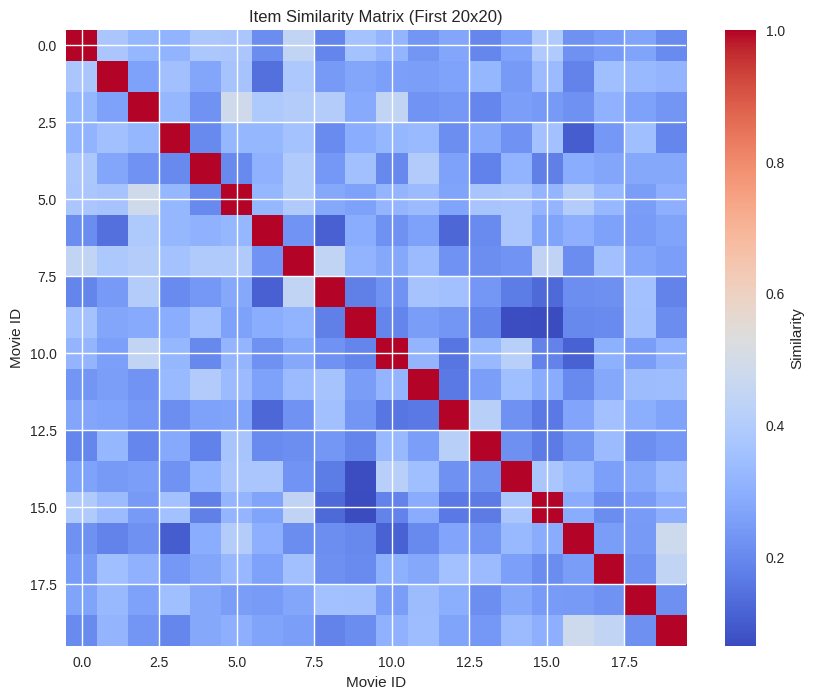


Item-based recommendations for User 1:
Movie 32 (Movie 32 - Sci-Fi): 3.06
Movie 42 (Movie 42 - Romance): 3.03
Movie 28 (Movie 28 - Drama): 3.00
Movie 27 (Movie 27 - Drama): 2.95
Movie 14 (Movie 14 - Comedy): 2.93

=== Comparison: User-based vs Item-based ===
User-based recommendations: [1, 18, 24, 3, 23]
Item-based recommendations: [32, 42, 28, 27, 14]
Overlap: 0 movies


In [7]:
# Item-Based Collaborative Filtering
print("=== Item-Based Collaborative Filtering ===")

# Calculate item similarity matrix
item_similarity = cosine_similarity(user_item_matrix_filled.T)
item_similarity_df = pd.DataFrame(item_similarity,
                                 index=user_item_matrix_filled.columns,
                                 columns=user_item_matrix_filled.columns)

print(f"Item Similarity Matrix Shape: {item_similarity_df.shape}")
print(f"\nItem Similarity Matrix (first 5x5):")
print(item_similarity_df.iloc[:5, :5].round(3))

# Visualize item similarity
plt.figure(figsize=(10, 8))
plt.imshow(item_similarity_df.iloc[:20, :20], cmap='coolwarm', aspect='auto')
plt.colorbar(label='Similarity')
plt.title('Item Similarity Matrix (First 20x20)')
plt.xlabel('Movie ID')
plt.ylabel('Movie ID')
plt.show()

# Function to get top similar items
def get_top_similar_items(movie_id, n=5):
    if movie_id not in item_similarity_df.index:
        return pd.Series()

    item_similarities = item_similarity_df.loc[movie_id].sort_values(ascending=False)
    # Remove self-similarity
    item_similarities = item_similarities[item_similarities.index != movie_id]
    return item_similarities.head(n)

# Function to recommend movies using item-based filtering
def recommend_movies_item_based(user_id, n_recommendations=5):
    if user_id not in user_item_matrix.index:
        return pd.Series()

    # Get user's rated movies
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings.notna()]

    if len(rated_movies) == 0:
        return pd.Series()

    # Calculate predictions for unrated movies
    recommendations = {}

    for movie_id in user_item_matrix.columns:
        if movie_id not in rated_movies.index:  # Only predict unrated movies
            weighted_sum = 0
            similarity_sum = 0

            for rated_movie_id, rating in rated_movies.items():
                similarity = item_similarity_df.loc[movie_id, rated_movie_id]
                weighted_sum += similarity * rating
                similarity_sum += abs(similarity)

            if similarity_sum > 0:
                predicted_rating = weighted_sum / similarity_sum
                recommendations[movie_id] = predicted_rating

    # Sort by predicted rating
    recommendations_series = pd.Series(recommendations).sort_values(ascending=False)
    return recommendations_series.head(n_recommendations)

# Test item-based recommendations
print(f"\nItem-based recommendations for User {test_user_id}:")
item_recommendations = recommend_movies_item_based(test_user_id, n_recommendations=5)
for movie_id, predicted_rating in item_recommendations.items():
    movie_title = movies_df[movies_df['movie_id'] == movie_id]['title'].iloc[0]
    movie_genre = movies_df[movies_df['movie_id'] == movie_id]['genre'].iloc[0]
    print(f"Movie {movie_id} ({movie_title} - {movie_genre}): {predicted_rating:.2f}")

# Compare user-based vs item-based recommendations
print(f"\n=== Comparison: User-based vs Item-based ===")
print(f"User-based recommendations: {list(recommendations.index)}")
print(f"Item-based recommendations: {list(item_recommendations.index)}")
print(f"Overlap: {len(set(recommendations.index) & set(item_recommendations.index))} movies")

=== Matrix Factorization using SVD ===
SVD Components: 20
User factors shape: (100, 20)
Item factors shape: (50, 20)
Explained variance ratio: 0.6972
Reconstruction MSE: 0.9144

SVD recommendations for User 1:
Movie 32 (Movie 32 - Sci-Fi): 2.69
Movie 33 (Movie 33 - Sci-Fi): 2.48
Movie 29 (Movie 29 - Drama): 1.96
Movie 42 (Movie 42 - Romance): 1.67
Movie 47 (Movie 47 - Romance): 1.27


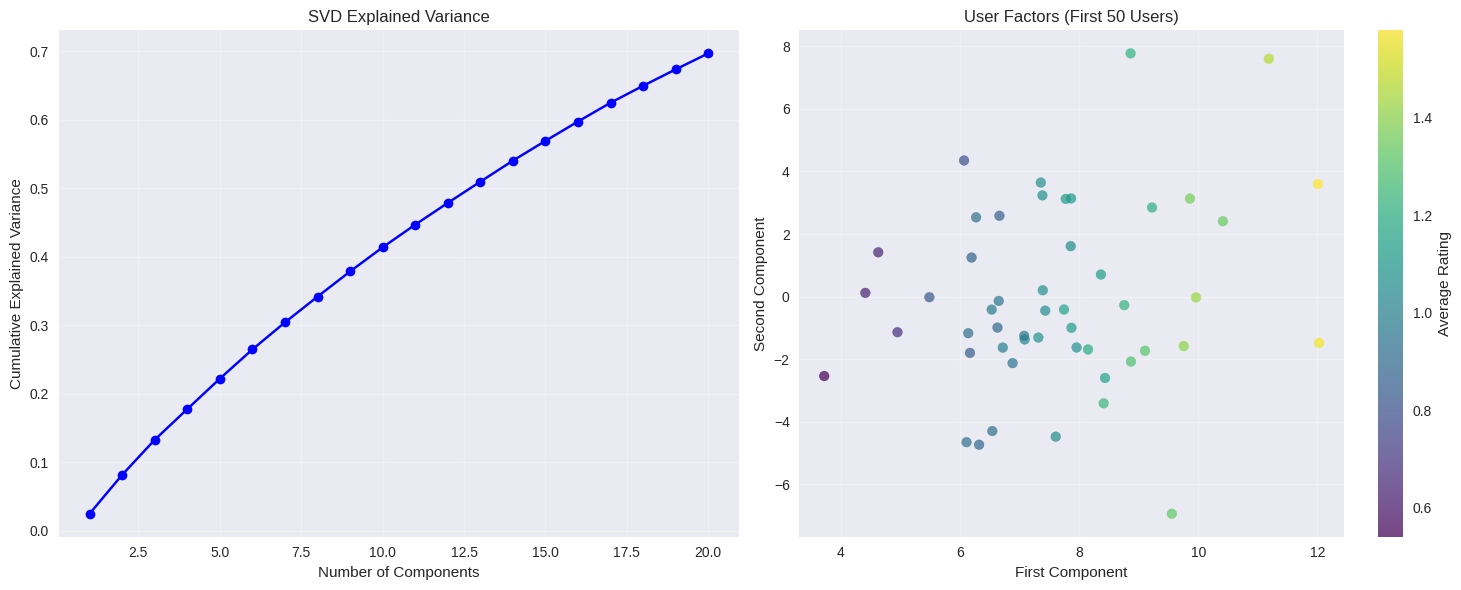

In [8]:
# Matrix Factorization (SVD)
print("=== Matrix Factorization using SVD ===")

# Apply SVD to the user-item matrix
n_components = min(20, min(user_item_matrix_filled.shape) - 1)
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit SVD
user_factors = svd.fit_transform(user_item_matrix_filled)
item_factors = svd.components_.T

print(f"SVD Components: {n_components}")
print(f"User factors shape: {user_factors.shape}")
print(f"Item factors shape: {item_factors.shape}")
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

# Reconstruct the matrix
reconstructed_matrix = user_factors @ item_factors.T
reconstruction_error = mean_squared_error(user_item_matrix_filled, reconstructed_matrix)
print(f"Reconstruction MSE: {reconstruction_error:.4f}")

# Function to recommend movies using SVD
def recommend_movies_svd(user_id, n_recommendations=5):
    if user_id not in user_item_matrix.index:
        return pd.Series()

    # Get user index
    user_idx = user_item_matrix.index.get_loc(user_id)

    # Get user's rated movies
    user_ratings = user_item_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings.notna()].index

    # Calculate predicted ratings
    user_vector = user_factors[user_idx]
    predicted_ratings = user_vector @ item_factors.T

    # Create recommendations for unrated movies
    recommendations = {}
    for i, movie_id in enumerate(user_item_matrix.columns):
        if movie_id not in rated_movies:
            recommendations[movie_id] = predicted_ratings[i]

    # Sort by predicted rating
    recommendations_series = pd.Series(recommendations).sort_values(ascending=False)
    return recommendations_series.head(n_recommendations)

# Test SVD recommendations
print(f"\nSVD recommendations for User {test_user_id}:")
svd_recommendations = recommend_movies_svd(test_user_id, n_recommendations=5)
for movie_id, predicted_rating in svd_recommendations.items():
    movie_title = movies_df[movies_df['movie_id'] == movie_id]['title'].iloc[0]
    movie_genre = movies_df[movies_df['movie_id'] == movie_id]['genre'].iloc[0]
    print(f"Movie {movie_id} ({movie_title} - {movie_genre}): {predicted_rating:.2f}")

# Visualize SVD components
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Explained variance
axes[0].plot(range(1, len(svd.explained_variance_ratio_) + 1),
             np.cumsum(svd.explained_variance_ratio_), 'bo-')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('SVD Explained Variance')
axes[0].grid(True, alpha=0.3)

# User factors visualization
scatter = axes[1].scatter(user_factors[:50, 0], user_factors[:50, 1],
                          c=user_item_matrix_filled.iloc[:50].mean(axis=1),
                          cmap='viridis', alpha=0.7)
axes[1].set_xlabel('First Component')
axes[1].set_ylabel('Second Component')
axes[1].set_title('User Factors (First 50 Users)')
plt.colorbar(scatter, ax=axes[1], label='Average Rating')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== Evaluation: Precision at K ===

Evaluation Results:

User-based:
  Precision@5: 0.0000
  Recall@5: 0.0000
  Precision@10: 0.0000
  Recall@10: 0.0000

Item-based:
  Precision@5: 0.0000
  Recall@5: 0.0000
  Precision@10: 0.0000
  Recall@10: 0.0000

SVD:
  Precision@5: 0.0000
  Recall@5: 0.0000
  Precision@10: 0.0000
  Recall@10: 0.0000


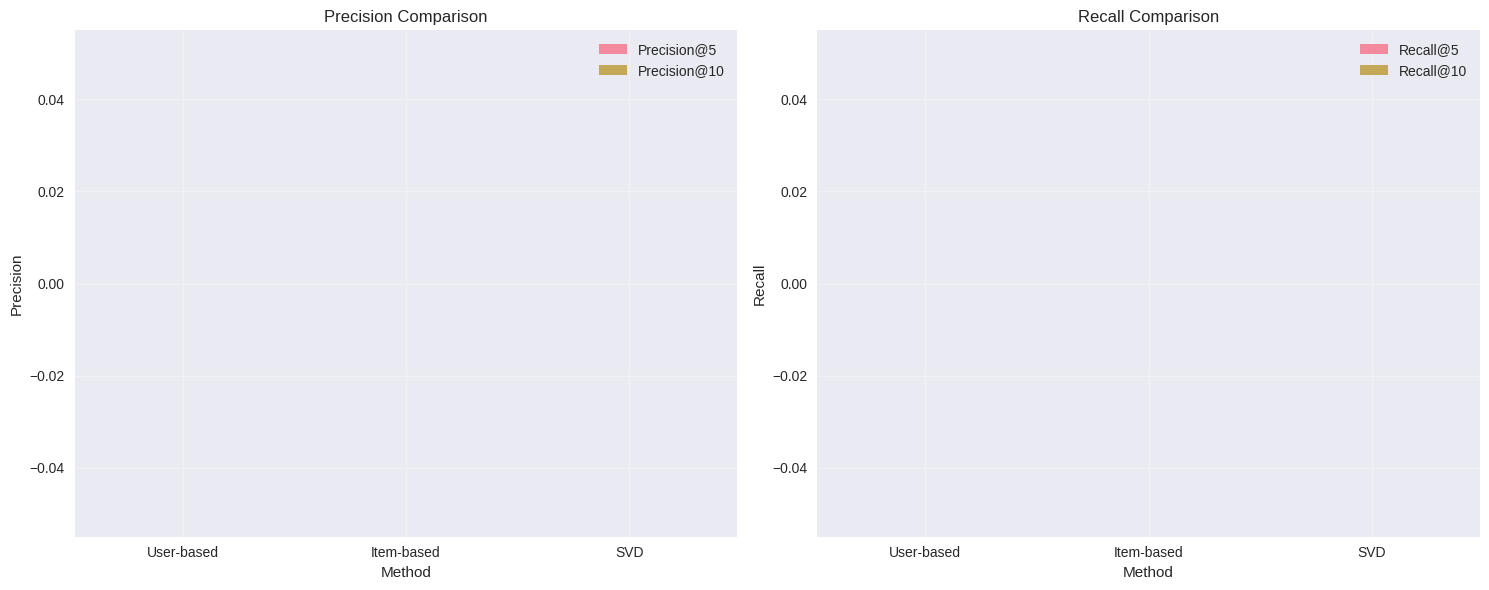

In [9]:
# Evaluation: Precision at K
print("=== Evaluation: Precision at K ===")

# Split data for evaluation
from sklearn.model_selection import train_test_split

# Create train/test split
train_ratings, test_ratings = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Create train matrix
train_matrix = train_ratings.pivot(index='user_id', columns='movie_id', values='rating')
train_matrix_filled = train_matrix.fillna(0)

# Function to calculate precision at K
def precision_at_k(recommended_items, relevant_items, k):
    if k == 0:
        return 0

    top_k_recommendations = recommended_items[:k]
    relevant_in_top_k = len(set(top_k_recommendations) & set(relevant_items))
    return relevant_in_top_k / k

# Function to calculate recall at K
def recall_at_k(recommended_items, relevant_items, k):
    if len(relevant_items) == 0:
        return 0

    top_k_recommendations = recommended_items[:k]
    relevant_in_top_k = len(set(top_k_recommendations) & set(relevant_items))
    return relevant_in_top_k / len(relevant_items)

# Evaluate different recommendation methods
def evaluate_recommendations(test_users, k_values=[5, 10]):
    results = {}

    for method_name, recommend_func in [
        ('User-based', lambda u: recommend_movies_user_based(u, n_recommendations=10)),
        ('Item-based', lambda u: recommend_movies_item_based(u, n_recommendations=10)),
        ('SVD', lambda u: recommend_movies_svd(u, n_recommendations=10))
    ]:
        precision_scores = {k: [] for k in k_values}
        recall_scores = {k: [] for k in k_values}

        for user_id in test_users:
            # Get user's test ratings (highly rated movies)
            user_test_ratings = test_ratings[test_ratings['user_id'] == user_id]
            relevant_items = user_test_ratings[user_test_ratings['rating'] >= 4]['movie_id'].tolist()

            if len(relevant_items) > 0:
                # Get recommendations
                recommendations = recommend_func(user_id)
                recommended_items = list(recommendations.index)

                # Calculate precision and recall for different k values
                for k in k_values:
                    precision_scores[k].append(precision_at_k(recommended_items, relevant_items, k))
                    recall_scores[k].append(recall_at_k(recommended_items, relevant_items, k))

        # Calculate average scores
        results[method_name] = {
            'precision': {k: np.mean(scores) for k, scores in precision_scores.items()},
            'recall': {k: np.mean(scores) for k, scores in recall_scores.items()}
        }

    return results

# Evaluate on a subset of users
test_users = test_ratings['user_id'].unique()[:20]  # Use first 20 users for evaluation
evaluation_results = evaluate_recommendations(test_users)

# Display results
print("\nEvaluation Results:")
for method, scores in evaluation_results.items():
    print(f"\n{method}:")
    for k in [5, 10]:
        precision = scores['precision'][k]
        recall = scores['recall'][k]
        print(f"  Precision@{k}: {precision:.4f}")
        print(f"  Recall@{k}: {recall:.4f}")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Precision comparison
methods = list(evaluation_results.keys())
k_values = [5, 10]
x_pos = np.arange(len(methods))
width = 0.35

precision_5 = [evaluation_results[method]['precision'][5] for method in methods]
precision_10 = [evaluation_results[method]['precision'][10] for method in methods]

axes[0].bar(x_pos - width/2, precision_5, width, label='Precision@5', alpha=0.8)
axes[0].bar(x_pos + width/2, precision_10, width, label='Precision@10', alpha=0.8)
axes[0].set_xlabel('Method')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision Comparison')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(methods)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Recall comparison
recall_5 = [evaluation_results[method]['recall'][5] for method in methods]
recall_10 = [evaluation_results[method]['recall'][10] for method in methods]

axes[1].bar(x_pos - width/2, recall_5, width, label='Recall@5', alpha=0.8)
axes[1].bar(x_pos + width/2, recall_10, width, label='Recall@10', alpha=0.8)
axes[1].set_xlabel('Method')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall Comparison')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(methods)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Summary and Conclusions
print("=== Summary and Conclusions ===")

# Final comparison of all methods
print("\nFinal Method Comparison:")
comparison_df = pd.DataFrame({
    'Method': methods,
    'Precision@5': [evaluation_results[method]['precision'][5] for method in methods],
    'Precision@10': [evaluation_results[method]['precision'][10] for method in methods],
    'Recall@5': [evaluation_results[method]['recall'][5] for method in methods],
    'Recall@10': [evaluation_results[method]['recall'][10] for method in methods]
})

print(comparison_df.round(4))

# Find best method
best_method = comparison_df.loc[comparison_df['Precision@5'].idxmax(), 'Method']
print(f"\nBest Method (by Precision@5): {best_method}")

print(f"\nKey Insights:")
print(f"1. Dataset sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
print(f"2. Number of users: {n_users}")
print(f"3. Number of movies: {n_movies}")
print(f"4. Total ratings: {len(ratings_df)}")
print(f"5. Best performing method: {best_method}")
print(f"6. SVD explained variance: {svd.explained_variance_ratio_.sum():.4f}")

print(f"\nBusiness Applications:")
print(f"1. Netflix-style movie recommendations")
print(f"2. E-commerce product recommendations")
print(f"3. Music streaming service recommendations")
print(f"4. Book recommendation systems")
print(f"5. Social media content recommendations")

print(f"\nModel Deployment Recommendations:")
print(f"1. Use hybrid approaches combining multiple methods")
print(f"2. Implement real-time recommendation updates")
print(f"3. Consider cold-start problem for new users/items")
print(f"4. Regular model retraining with new data")
print(f"5. A/B testing for recommendation algorithms")
print(f"6. Monitor recommendation diversity and novelty")

=== Summary and Conclusions ===

Final Method Comparison:
       Method  Precision@5  Precision@10  Recall@5  Recall@10
0  User-based          0.0           0.0       0.0        0.0
1  Item-based          0.0           0.0       0.0        0.0
2         SVD          0.0           0.0       0.0        0.0

Best Method (by Precision@5): User-based

Key Insights:
1. Dataset sparsity: 0.6726 (67.26%)
2. Number of users: 100
3. Number of movies: 50
4. Total ratings: 1637
5. Best performing method: User-based
6. SVD explained variance: 0.6972

Business Applications:
1. Netflix-style movie recommendations
2. E-commerce product recommendations
3. Music streaming service recommendations
4. Book recommendation systems
5. Social media content recommendations

Model Deployment Recommendations:
1. Use hybrid approaches combining multiple methods
2. Implement real-time recommendation updates
3. Consider cold-start problem for new users/items
4. Regular model retraining with new data
5. A/B testing f